<a href="https://colab.research.google.com/github/HYChangTAMU/FINC637_Group2_Fall_2023/blob/main/Assignment4/Project4_Hao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Date 11/16/2023
%cd ./drive/MyDrive/Assignment4/data


#-------------------------------------------------------------------------------

!pip install mat73
import mat73
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import json
import datetime
import pytz
from statsmodels.stats.weightstats import ttest_ind, ttost_paired
from sklearn.metrics import r2_score
from google.colab import files


#-------------------------------------------------------------------------------

# f5 = pd.read_csv('./5_factors_daily.csv')
# mom = pd.read_csv('./momentum_factor_daily.csv')
# fac6 = f5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].merge(mom, on = 'Date', how = 'inner')
# fac6['RF'] = f5['RF']
# fac6.rename(columns = {'Mom   ': 'Mom'}, inplace = True)
# fac6.to_csv("6_factors_daily.csv", index = False)

f6 = pd.read_csv('./6_factors_daily.csv')
f6.drop(range(14979, 15123), inplace = True)


#-------------------------------------------------------------------------------

daily_return = pd.DataFrame(mat73.loadmat('./stock_daily_return.mat')['stock_ret'])
daily_return[0] = daily_return[0].astype('int64')
daily_return.rename({0: 'Date'}, axis=1, inplace=True)
daily_return.drop(range(879), inplace = True)
daily_return.reset_index(drop = True, inplace = True)


#-------------------------------------------------------------------------------

# daily_cap = pd.DataFrame(mat73.loadmat('./stock_daily_market_cap.mat')['stock_cap'])
# daily_cap[0] = daily_cap[0].astype('int64')
# daily_cap.rename({0: 'Date'}, axis=1, inplace=True)
# daily_cap.drop(range(879), inplace = True)
# daily_cap.reset_index(drop = True, inplace = True)

# window_end = [month_start_end[2*n+23] for n in range(703)]
# window_end

# window_cap = daily_cap.loc[daily_cap['Date'].isin(window_end)]
# window_cap.reset_index(drop = True, inplace = True)
# window_cap.to_csv('./window_cap.csv', index = False)

window_cap = pd.read_csv('./window_cap.csv')


#-------------------------------------------------------------------------------

month_start_end = []
dates = f6['Date'][0:-1].tolist()
for i, d in enumerate(dates):
  if d%100 < dates[i-1]%100:
    month_start_end.append(dates[i-1])
    month_start_end.append(d)
month_start_end.append(month_start_end[0])
month_start_end = month_start_end[1:]

mse_index = []
for i in range(len(month_start_end)//2):
  mse_index.append(f6['Date'].index[f6['Date'] == month_start_end[2*i]].tolist())
  mse_index.append(f6['Date'].index[f6['Date'] == month_start_end[2*i + 1]].tolist())

month_start_end_index = []
for i in range(len(month_start_end)):
  month_start_end_index.append(mse_index[i][0])
month_start_end[-1] = 20221230
month_start_end_index[-1] = 14978

In [ ]:
def get_betas(n):
  # n_min = 0
  # n_max = 702
  fac_data = f6[month_start_end_index[2*n]:month_start_end_index[2*n+23]+1]
  fac_data.drop(columns = 'Date', inplace = True)

  ret_data = daily_return[month_start_end_index[2*n]:month_start_end_index[2*n+23]+1]
  ret_data.dropna(how = 'any', axis = 1, inplace = True)
  ret_data.drop(columns = 'Date', inplace = True)
  ret_data = ret_data.sub(fac_data['RF'], axis = 0)

  fac_data.drop(columns = 'RF', inplace = True)

  model = sm.OLS(ret_data, sm.add_constant(fac_data)).fit()
  betas = model.params.set_axis(ret_data.columns, axis=1)
  betas.to_csv('./betas/' + str(n))


#-------------------------------------------------------------------------------

def read_betas(n, date_range = False):
  rdata = pd.read_csv('./betas/' + str(n)).set_index('Unnamed: 0')
  rdata.index.name = None
  if date_range:
    print('date :', month_start_end[2*n], 'to', month_start_end[2*n+23])
    print('index:', month_start_end_index[2*n], 'to', month_start_end_index[2*n+23])
  return rdata


#-------------------------------------------------------------------------------

def single_sort(colm):
  sort_group = [0 for x in range(703)]
  for n in range(703):
    sort_group[n] = [x.to_list() for x in np.array_split(read_betas(n, False).sort_values(by = [colm], axis = 1, ascending = False).columns, 25)]

  return sort_group


#-------------------------------------------------------------------------------

def double_sort(colm1, colm2):
  sort_group = [0 for x in range(703)]
  for n in range(703):
    sort_group[n] = [x.to_list() for x in np.array_split(read_betas(n, False).sort_values(by = [colm1], axis = 1, ascending = False).columns, 5)]
    sort_group[n] = [x.to_list() for x in np.array_split(read_betas(n, False)[sort_group[n][0]].sort_values(by = [colm2], axis = 1, ascending = False).columns, 5)] + [x.to_list() for x in np.array_split(read_betas(n, False)[sort_group[n][1]].sort_values(by = [colm2], axis = 1, ascending = False).columns, 5)] + [x.to_list() for x in np.array_split(read_betas(n, False)[sort_group[n][2]].sort_values(by = [colm2], axis = 1, ascending = False).columns, 5)] + [x.to_list() for x in np.array_split(read_betas(n, False)[sort_group[n][3]].sort_values(by = [colm2], axis = 1, ascending = False).columns, 5)] + [x.to_list() for x in np.array_split(read_betas(n, False)[sort_group[n][4]].sort_values(by = [colm2], axis = 1, ascending = False).columns, 5)]

  return sort_group


#-------------------------------------------------------------------------------

def get_window_return(n):
  # n_min = 0
  # n_max = 702

  ret_data = daily_return[month_start_end_index[2*n]:month_start_end_index[2*n+23]+1]
  ret_data.dropna(how = 'any', axis = 1, inplace = True)
  ret_data.drop(columns = 'Date', inplace = True)
  ret_data.columns = [str(x) for x in ret_data.columns]
  ret_data = ret_data.apply(lambda x: 1 + x , axis = 1)
  ret_data_exp = ret_data.product(axis=0).apply(lambda x: x - 1)

  return ret_data_exp


#-------------------------------------------------------------------------------
def long_short_sort():
  sort_group = [0 for x in range(703)]
  for n in range(703):
    sort_group[n] = [x.to_list() for x in np.array_split(get_window_return(n).sort_values(axis = 0, ascending = False).index, 10)]

  return sort_group

In [ ]:
# for n in range(703):
#   get_betas(n)


#-------------------------------------------------------------------------------

# Mkt_group = single_sort('Mkt-RF')
# with open("../Mkt_portfolios/Mkt_groups", "w") as Mkt:
#   json.dump(Mkt_group, Mkt)

# with open("../Mkt_portfolios/Mkt_groups", "r") as Mkt:
#   Mkt_group = json.load(Mkt)


#-------------------------------------------------------------------------------

# SMB_group = single_sort('SMB')
# with open("../SMB_portfolios/SMB_groups", "w") as SMB:
#   json.dump(SMB_group, SMB)

# with open("../SMB_portfolios/SMB_groups", "r") as SMB:
#   SMB_group = json.load(SMB)


#-------------------------------------------------------------------------------

# HML_group = single_sort('HML')
# with open("../HML_portfolios/HML_groups", "w") as HML:
#   json.dump(HML_group, HML)

# with open("../HML_portfolios/HML_groups", "r") as HML:
#   HML_group = json.load(HML)


#-------------------------------------------------------------------------------

# HML_group = single_sort('HML')
# with open("../HML_portfolios/HML_groups", "w") as HML:
#   json.dump(HML_group, HML)

# with open("../HML_portfolios/HML_groups", "r") as HML:
#   HML_group = json.load(HML)


#-------------------------------------------------------------------------------

# RMW_group = single_sort('RMW')
# with open("../RMW_portfolios/RMW_groups", "w") as RMW:
#   json.dump(RMW_group, RMW)

# with open("../RMW_portfolios/RMW_groups", "r") as RMW:
#   RMW_group = json.load(RMW)


#-------------------------------------------------------------------------------

# CMA_group = single_sort('CMA')
# with open("../CMA_portfolios/CMA_groups", "w") as CMA:
#   json.dump(CMA_group, CMA)

# with open("../CMA_portfolios/CMA_groups", "r") as CMA:
#   CMA_group = json.load(CMA)


#-------------------------------------------------------------------------------

# Mom_group = single_sort('Mom')
# with open("../Mom_portfolios/Mom_groups", "w") as Mom:
#   json.dump(Mom_group, Mom)

# with open("../Mom_portfolios/Mom_groups", "r") as Mom:
#   Mom_group = json.load(Mom)


#-------------------------------------------------------------------------------

# SMB_Mkt_group = double_sort('SMB', 'Mkt-RF')
# with open("../SMB_Mkt_portfolios/SMB_Mkt_groups", "w") as SMB_Mkt:
#   json.dump(SMB_Mkt_group, SMB_Mkt)

# with open("../SMB_Mkt_portfolios/SMB_Mkt_groups", "r") as SMB_Mkt:
#   SMB_Mkt_group = json.load(SMB_Mkt)


#-------------------------------------------------------------------------------

# SMB_HML_group = double_sort('SMB', 'HML')
# with open("../SMB_HML_portfolios/SMB_HML_groups", "w") as SMB_HML:
#   json.dump(SMB_HML_group, SMB_HML)

# with open("../SMB_HML_portfolios/SMB_HML_groups", "r") as SMB_HML:
#   SMB_HML_group = json.load(SMB_HML)


#-------------------------------------------------------------------------------

# Mom_LS_group = long_short_sort('Mom')
# with open("../Mom_LS_portfolios/Mom_LS_groups", "w") as Mom_LS:
#   json.dump(Mom_LS_group, Mom_LS)

# with open("../Mom_LS_portfolios/Mom_LS_groups", "r") as Mom_LS:
#   Mom_LS_group = json.load(Mom_LS)

In [ ]:
def wx_returns(n, sorted_group , p = 702):
  result_dict = {'Re': [], 'Rv': [], 'Rs': []}
  for t in range(p):
    # equal weights
    we = 1 / len(sorted_group[t][n])
    we_list = [we for x in sorted_group[t][n]]

    # value weights
    wv_list = window_cap[sorted_group[t][n]].iloc[t].tolist()
    s = sum(wv_list)
    wv_list = [x / s for x in wv_list]

    # 1/sigma weights
    f6_window = f6.iloc[month_start_end_index[2*t]:month_start_end_index[2*t+23]+1][['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']]
    f6_window = f6_window.assign(const = lambda x: 1)
    f6_window = f6_window[['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']]

    pred_ret = f6_window.dot(read_betas(t)[sorted_group[t][n]])

    real_ret = daily_return[[int(x) for x in sorted_group[t][n]]].iloc[month_start_end_index[2*t]:month_start_end_index[2*t+23]+1]
    real_ret.columns = [str(x) for x in real_ret.columns]
    real_ret = real_ret.sub(f6.iloc[month_start_end_index[2*t]:month_start_end_index[2*t+23]+1]['RF'], axis = 0)

    ws_list = real_ret.subtract(pred_ret, axis = 0).describe().iloc[2].tolist()
    ws_list = [1 / x for x in ws_list]
    s = sum(ws_list)
    ws_list = [x / s for x in ws_list]

    # return of the period
    real_ret = daily_return[[int(x) for x in sorted_group[t][n]]].iloc[month_start_end_index[2*t+23]+1:month_start_end_index[2*t+25]+1]
    real_ret.columns = [str(x) for x in real_ret.columns]
    real_ret = real_ret.apply(lambda x: 1 + x , axis = 1)
    real_ret_exp = real_ret.product(axis=0).apply(lambda x: x - 1)

    # 3 weights and returns
    comb_df = pd.DataFrame({"We" : we_list, 'Wv' : wv_list, 'Ws': ws_list, 'Rt+1': real_ret_exp}, index = sorted_group[t][n])

    result_dict['Re'].append(comb_df['We'].dot(comb_df['Rt+1']))
    result_dict['Rv'].append(comb_df['Wv'].dot(comb_df['Rt+1']))
    result_dict['Rs'].append(comb_df['Ws'].dot(comb_df['Rt+1']))

  return pd.DataFrame(result_dict, index = [str(t) for t in range(p)])


#-------------------------------------------------------------------------------

def all_group_wx_returns_stats(sorted_group, colm):
  all_group = {}
  print('start running at ' + datetime.datetime.now(pytz.timezone('US/Central')).strftime("%Y-%m-%d %H:%M:%S"))
  for n in range(16, 25):
    all_group[n] = wx_returns(n, sorted_group, p = 702).describe().iloc[1:3]
    print('finished group: ' + str(n) + ' at ' + datetime.datetime.now(pytz.timezone('US/central')).strftime("%Y-%m-%d %H:%M:%S"))
    all_group[n].to_csv('/content/drive/MyDrive/Assignment4/' + colm + '_portfolios/return_' + str(n) + '.csv')


#-------------------------------------------------------------------------------

def long_short_returns_no_delay(n, sorted_group , p = 702):
  result_dict = {'Re': []}
  for t in range(p):
    # equal weights
    we = 1 / len(sorted_group[t][n])
    we_list = [we for x in sorted_group[t][n]]

    # return of the period
    real_ret = daily_return[[int(x) for x in sorted_group[t][n]]].iloc[month_start_end_index[2*t+23]+1:month_start_end_index[2*t+25]+1]
    real_ret.columns = [str(x) for x in real_ret.columns]
    real_ret = real_ret.apply(lambda x: 1 + x , axis = 1)
    real_ret_exp = real_ret.product(axis=0).apply(lambda x: x - 1)

    comb_df = pd.DataFrame({"We" : we_list, 'Rt+1': real_ret_exp}, index = sorted_group[t][n])

    result_dict['Re'].append(comb_df['We'].dot(comb_df['Rt+1']))

  return pd.DataFrame(result_dict, index = [str(t) for t in range(p)])


#-------------------------------------------------------------------------------

def long_short_returns_with_delay(n, sorted_group , p = 702):
  result_dict = {'Re': []}
  for t in range(p):
    # equal weights
    we = 1 / len(sorted_group[t][n])
    we_list = [we for x in sorted_group[t][n]]

    # return of the period
    real_ret = daily_return[[int(x) for x in sorted_group[t][n]]].iloc[month_start_end_index[2*t+23]+11:month_start_end_index[2*t+25]+11]
    real_ret.columns = [str(x) for x in real_ret.columns]
    real_ret = real_ret.apply(lambda x: 1 + x , axis = 1)
    real_ret_exp = real_ret.product(axis=0).apply(lambda x: x - 1)

    comb_df = pd.DataFrame({"We" : we_list, 'Rt+1': real_ret_exp}, index = sorted_group[t][n])

    result_dict['Re'].append(comb_df['We'].dot(comb_df['Rt+1']))

  return pd.DataFrame(result_dict, index = [str(t) for t in range(p)])


#-------------------------------------------------------------------------------

def long_short_returns_no_delay_stats(sorted_group, colm):
  ls_test0 = long_short_returns_no_delay(0, sorted_group , p = 702)
  ls_test9 = long_short_returns_no_delay(9, sorted_group , p = 702)

  return ls_test0.sub(ls_test9).describe().iloc[1:3]


#-------------------------------------------------------------------------------

def long_short_returns_with_delay_stats(sorted_group, colm):
  ls_test0 = long_short_returns_with_delay(0, sorted_group , p = 702)
  ls_test9 = long_short_returns_with_delay(9, sorted_group , p = 702)

  return ls_test0.sub(ls_test9).describe().iloc[1:3]

In [ ]:
# all_group_wx_returns_stats(Mkt_group, 'Mkt')
# all_group_wx_returns_stats(SMB_group, 'SMB')
# all_group_wx_returns_stats(HML_group, 'HML')
# all_group_wx_returns_stats(RMW_group, 'RMW')
# all_group_wx_returns_stats(CMA_group, 'CMA')
# all_group_wx_returns_stats(Mom_group, 'Mom')
# all_group_wx_returns_stats(SMB_Mkt_group, 'SMB_Mkt')
# all_group_wx_returns_stats(SMB_HML_group, 'SMB_HML')

In [ ]:
def read_ES(colm):
  all_group = {}
  for n in range(25):
    all_group[n] = pd.read_csv('/content/drive/MyDrive/Assignment4/' + colm + '_portfolios/return_' + str(n) + '.csv', index_col = 0)

  return all_group


#-------------------------------------------------------------------------------

def plot_ES(data, Rx, x_scale = 0.1, y_scale = 0.1):
  x = [data[n][Rx].tolist()[1] for n in range(25)]
  y = [data[n][Rx].tolist()[0] for n in range(25)]
  plt.title(Rx)
  plt.scatter(x, y)
  plt.xlim(0,  x_scale)
  plt.ylim(0,  y_scale)
  plt.xlabel("std[R]")
  plt.ylabel("E[R]")
  plt.plot(x[1:], y[1:], 'bo')
  plt.plot(x[0], y[0], 'rD')
  plt.plot(x, y)
  plt.show()


#-------------------------------------------------------------------------------

def all_portfolio_plots(colm, x_scale = 0.1, y_scale = 0.1):
  data = read_ES(colm)

  print('E[R] vs. std[R] plot for risk factor: ' + colm)
  print('The red dot has the highest beta.')
  plot_ES(data, 'Re', x_scale, y_scale)
  plot_ES(data, 'Rv', x_scale, y_scale)
  plot_ES(data, 'Rs', x_scale, y_scale)


#-------------------------------------------------------------------------------

def double_sort_plots(data, Rx, x_scale = 0.1, y_scale = 0.1):
  x = [data[n][Rx].tolist()[1] for n in range(25)]
  y = [data[n][Rx].tolist()[0] for n in range(25)]
  plt.title(Rx)
  plt.scatter(x, y)
  plt.xlim(0.02,  x_scale)
  plt.ylim(0.004,  y_scale)
  plt.xlabel("std[R]")
  plt.ylabel("E[R]")
  plt.plot(x[1:5], y[1:5], 'bo')
  plt.plot(x[:5], y[:5])
  plt.plot(x[5:10], y[5:10])
  plt.plot(x[10:15], y[10:15])
  plt.plot(x[15:20], y[15:20])
  plt.plot(x[20:], y[20:])
  plt.plot([x[5], x[10], x[15], x[20]], [y[5], y[10], y[15], y[20]], 'r.')
  plt.plot([x[0]], [y[0]], 'rD')
  plt.plot([x[0], x[5], x[10], x[15], x[20]], [y[0], y[5], y[10], y[15], y[20]])
  plt.show()


#-------------------------------------------------------------------------------

def all_double_sort_plots(colm, x_scale = 0.1, y_scale = 0.1):
  data = read_ES(colm)

  print('E[R] vs. std[R] plot for risk factor: ' + colm)
  print('The red diamond has the highest' , colm[:3], 'and', colm[-3:],  'beta .')
  print('The red points have the highest' , colm[-3:],  'beta in their groups.')
  double_sort_plots(data, 'Re', x_scale, y_scale)
  double_sort_plots(data, 'Rv', x_scale, y_scale)
  double_sort_plots(data, 'Rs', x_scale, y_scale)

E[R] vs. std[R] plot for risk factor: Mkt
The red dot has the highest beta.


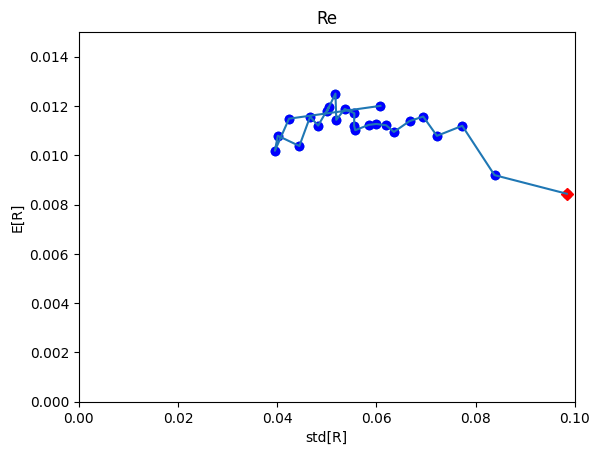

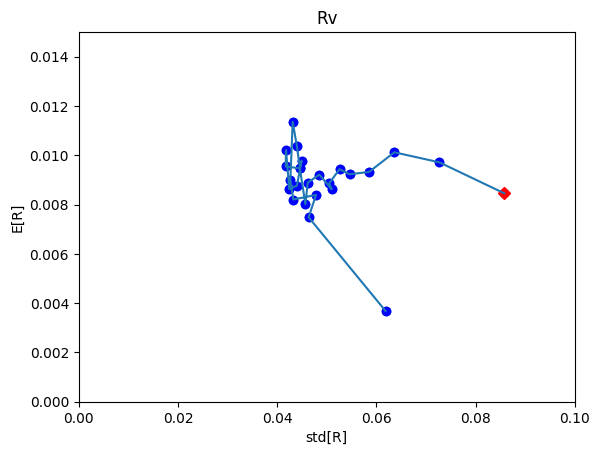

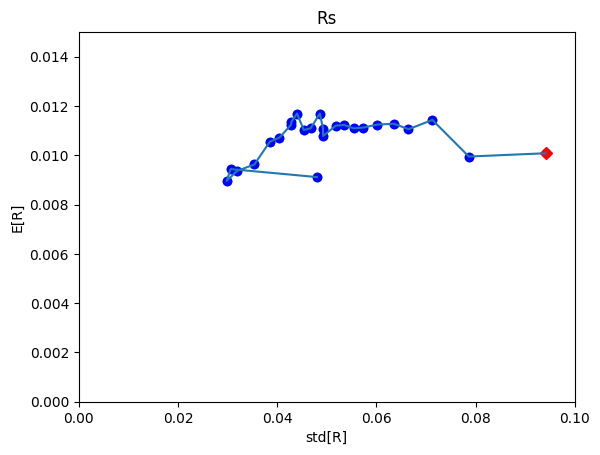

In [ ]:
all_portfolio_plots('Mkt', x_scale = 0.1, y_scale = 0.015)

E[R] vs. std[R] plot for risk factor: SMB
The red dot has the highest beta.


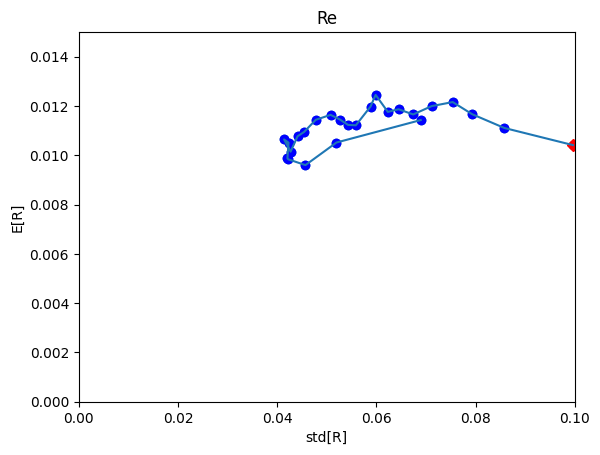

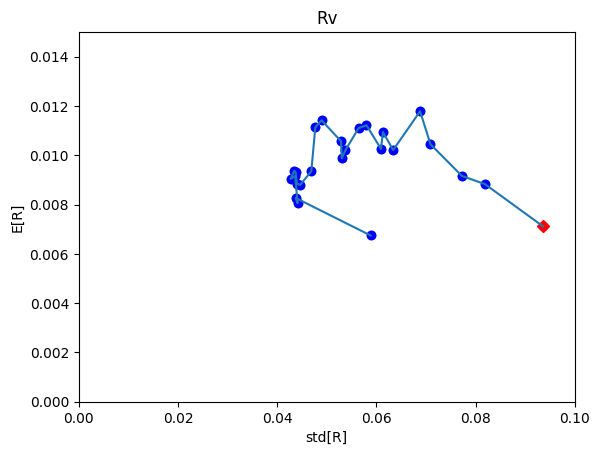

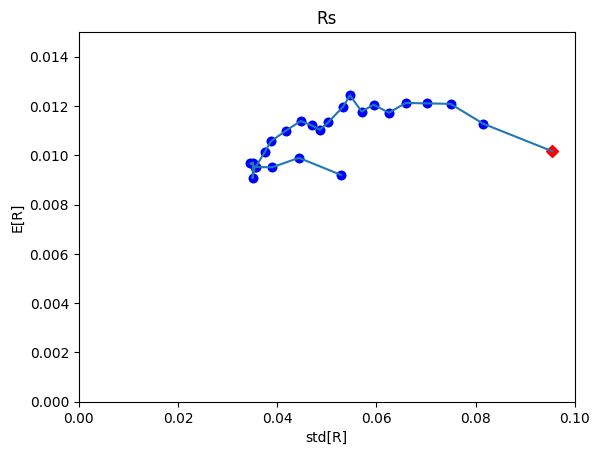

In [ ]:
all_portfolio_plots('SMB', x_scale = 0.1, y_scale = 0.015)

E[R] vs. std[R] plot for risk factor: HML
The red dot has the highest beta.


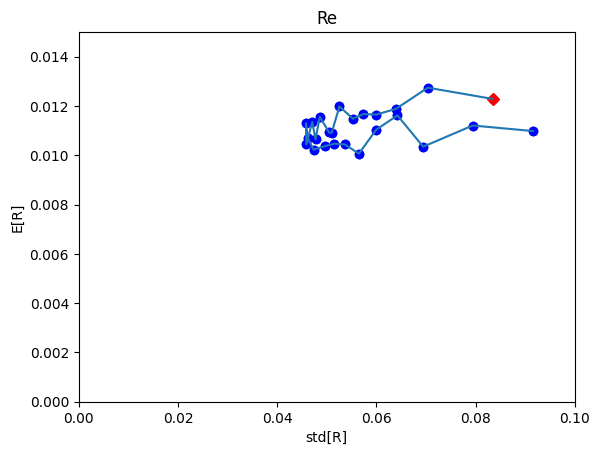

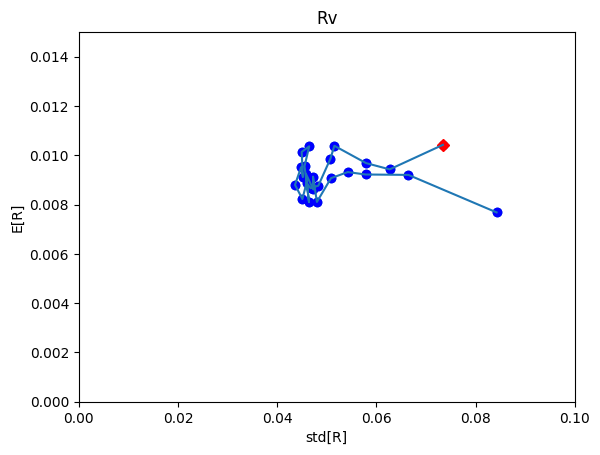

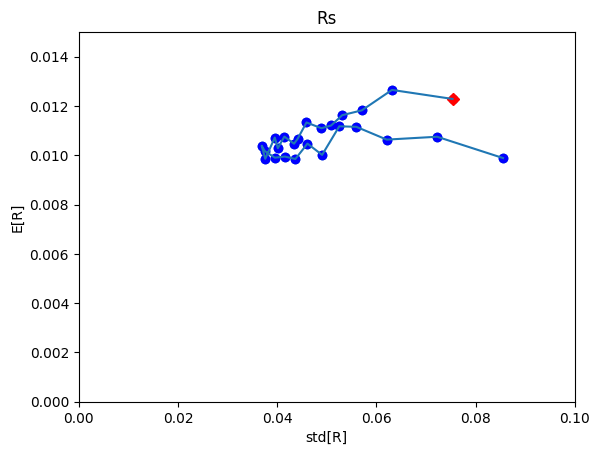

In [ ]:
all_portfolio_plots('HML', x_scale = 0.1, y_scale = 0.015)

E[R] vs. std[R] plot for risk factor: RMW
The red dot has the highest beta.


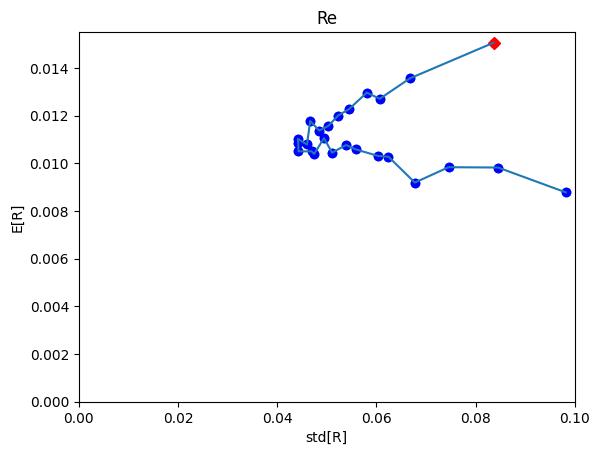

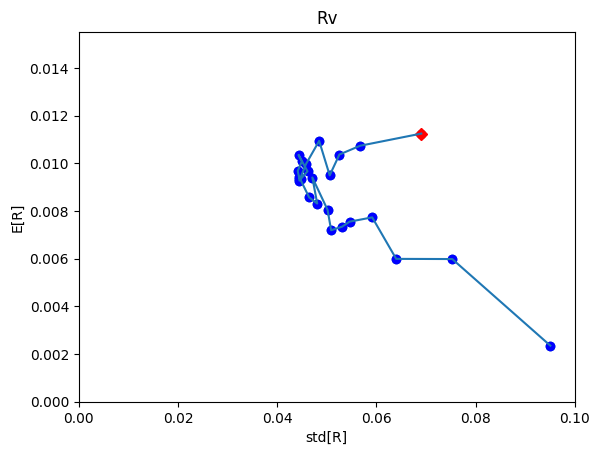

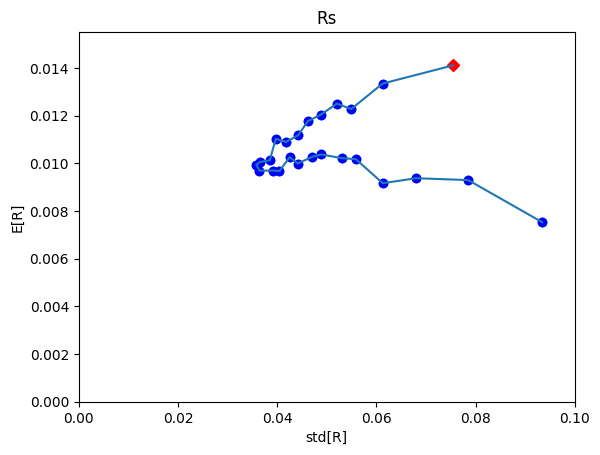

In [ ]:
all_portfolio_plots('RMW', x_scale = 0.1, y_scale = 0.0155)

E[R] vs. std[R] plot for risk factor: CMA
The red dot has the highest beta.


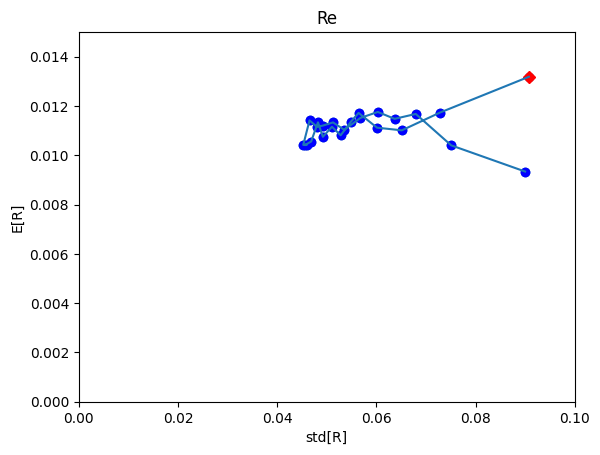

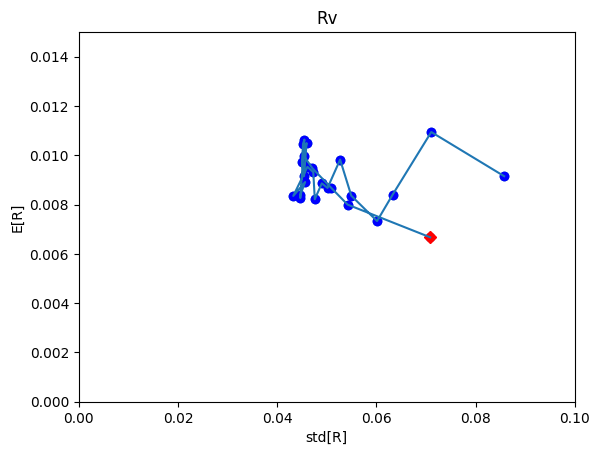

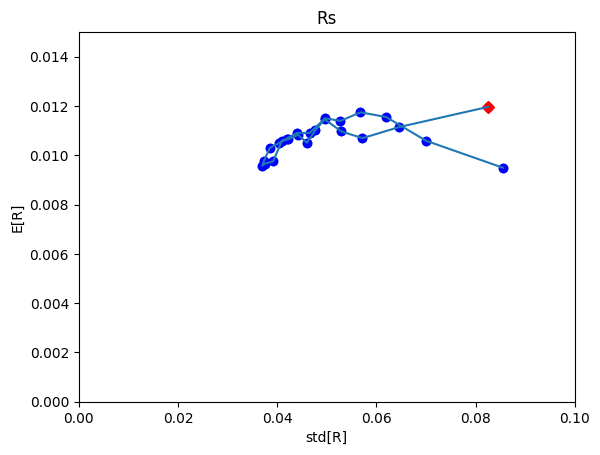

In [ ]:
all_portfolio_plots('CMA', x_scale = 0.1, y_scale = 0.015)

E[R] vs. std[R] plot for risk factor: Mom
The red dot has the highest beta.


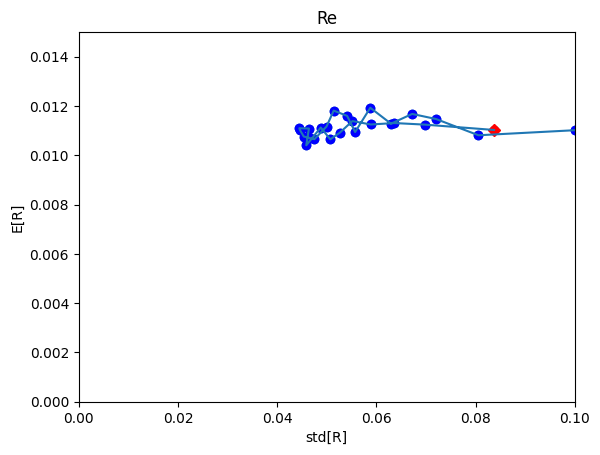

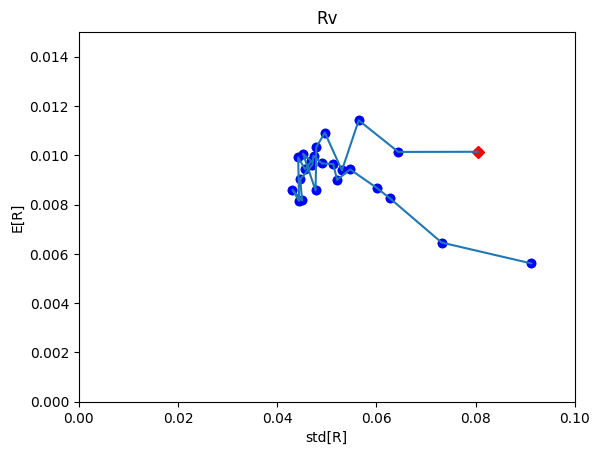

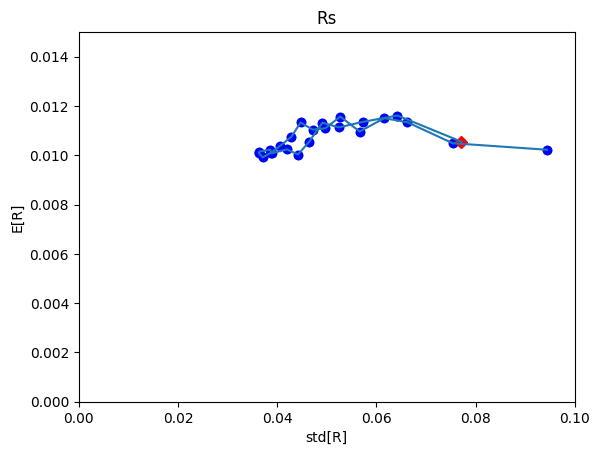

In [ ]:
all_portfolio_plots('Mom', x_scale = 0.1, y_scale = 0.015)

E[R] vs. std[R] plot for risk factor: SMB_Mkt
The red diamond has the highest SMB and Mkt beta .
The red points have the highest Mkt beta in their groups.


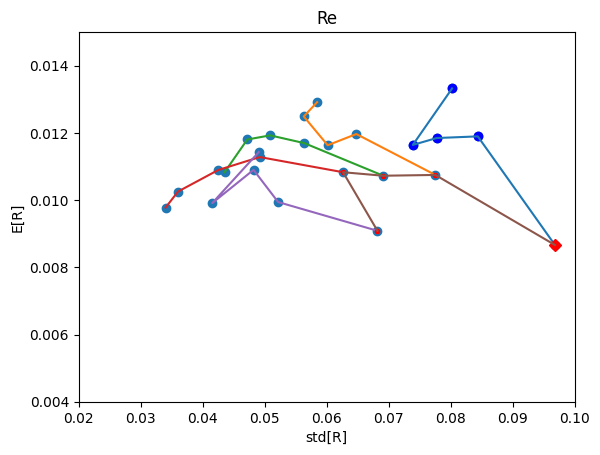

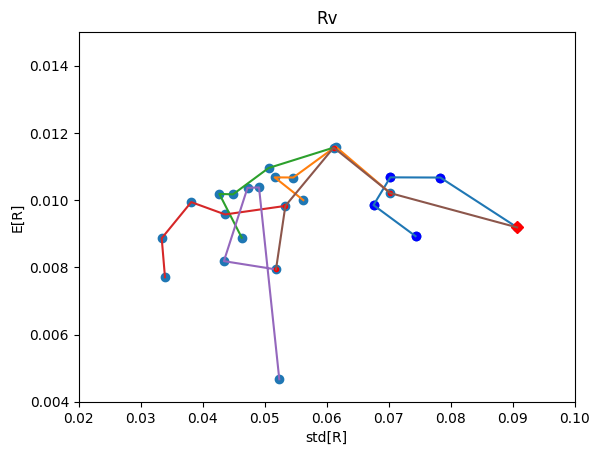

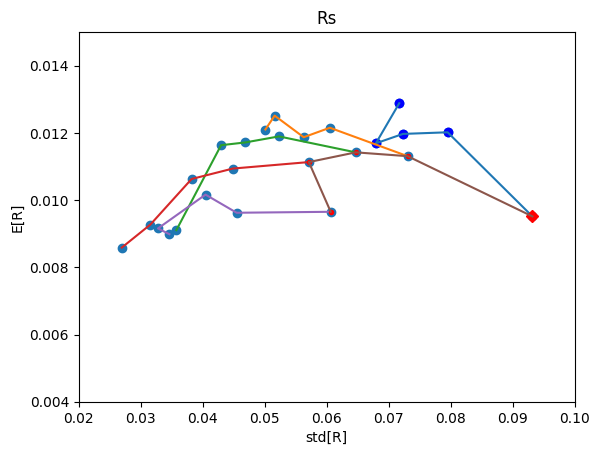

In [ ]:
all_double_sort_plots('SMB_Mkt', x_scale = 0.1, y_scale = 0.015)

E[R] vs. std[R] plot for risk factor: SMB_HML
The red diamond has the highest SMB and HML beta .
The red points have the highest HML beta in their groups.


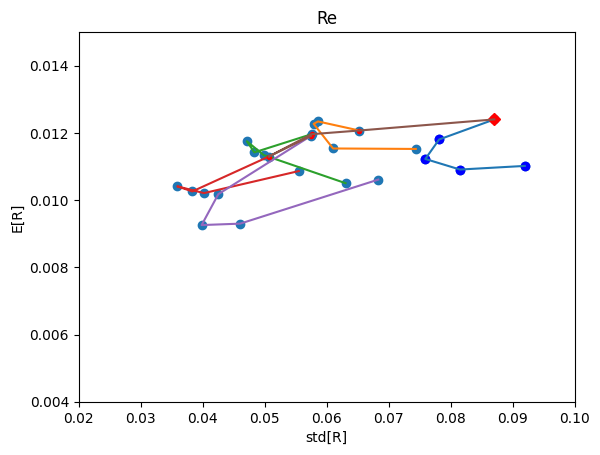

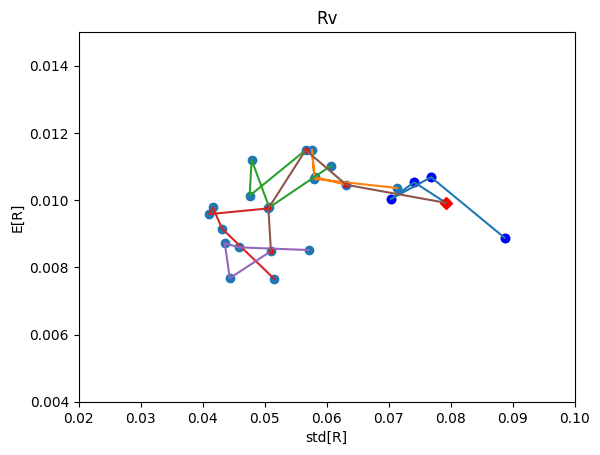

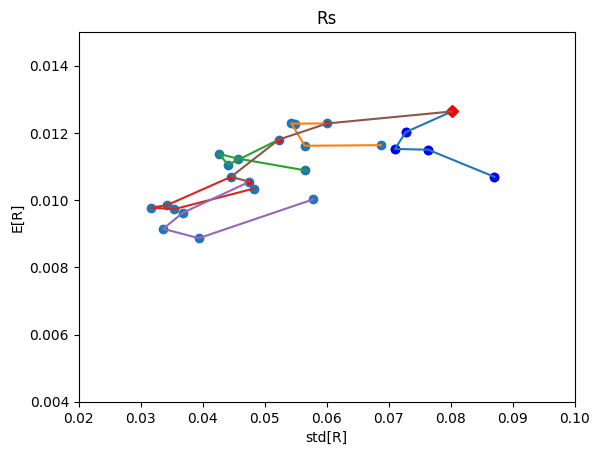

In [ ]:
all_double_sort_plots('SMB_HML', x_scale = 0.1, y_scale = 0.015)

In [ ]:
long_short_returns_no_delay_stats(Mom_LS_group, 'Mom_LS')

,Re
mean,0.003247
std,0.080601


In [ ]:
long_short_returns_with_delay_stats(Mom_LS_group, 'Mom_LS')

,Re
mean,0.00866
std,0.07148


In [ ]:
s1 = long_short_returns_no_delay(0, Mom_LS_group) - long_short_returns_no_delay(9, Mom_LS_group)
s2 = long_short_returns_with_delay(0, Mom_LS_group) - long_short_returns_with_delay(9, Mom_LS_group)

ttest_ind(s1, s2)

(array([-1.33131649]), array([0.18330132]), 1402.0)